# This is a tutorial of using spaVAE for the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.noise = 1
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.decoder_layers = [32]
        self.beta = 20
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.num_denoise_samples = 10000
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

(3639, 3000)
(3639, 2)
(49, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=3000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")


denoised_counts = model.batching_denoise_counts(X=loc, Y=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.denoised_counts_file, denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:29.89199890, NB loss:1.48231723, KLD loss:0.01576695, noise regularization:0.011494
Current kernel scale tensor([20.0054])
Training epoch 2, ELBO:28.96127945, NB loss:1.44444602, KLD loss:0.01579891, noise regularization:0.002828
Current kernel scale tensor([20.0111])
Training epoch 3, ELBO:28.25938256, NB loss:1.41044334, KLD loss:0.01648439, noise regularization:0.001702
Current kernel scale tensor([20.0169])
Training epoch 4, ELBO:27.66377018, NB loss:1.38097989, KLD loss:0.01763985, noise regularization:0.001327
Current kernel scale tensor([20.0227])
Training epoch 5, ELBO:27.17781501, NB loss:1.35632777, KLD loss:0.01883206, noise regularization:0.001621
Current kernel scale tensor([20.0286])
Training epoch 6, ELBO:26.71251609, NB loss:1.33314221, KLD loss:0.01949604, noise regularization:0.001509
Current kernel scale tensor([20.0344])
Training epoch 7, ELBO:26.28801170, NB loss:1.31215965, KLD loss:0.01981294, noise regularization:0.001250
Current 

Training epoch 57, ELBO:20.09009203, NB loss:1.00166509, KLD loss:0.02584263, noise regularization:0.001547
Current kernel scale tensor([20.2878])
Training epoch 58, ELBO:20.06567342, NB loss:1.00064646, KLD loss:0.02546315, noise regularization:0.001364
Current kernel scale tensor([20.2918])
Training epoch 59, ELBO:20.04340714, NB loss:0.99929039, KLD loss:0.02518055, noise regularization:0.001621
Current kernel scale tensor([20.2957])
Training epoch 60, ELBO:20.02731960, NB loss:0.99856882, KLD loss:0.02531698, noise regularization:0.001531
Current kernel scale tensor([20.2996])
Training epoch 61, ELBO:20.02659126, NB loss:0.99844138, KLD loss:0.02521035, noise regularization:0.001628
Current kernel scale tensor([20.3036])
Training epoch 62, ELBO:20.02414057, NB loss:0.99849372, KLD loss:0.02530015, noise regularization:0.001448
Current kernel scale tensor([20.3075])
Training epoch 63, ELBO:20.00112455, NB loss:0.99755489, KLD loss:0.02479134, noise regularization:0.001262
Current ke

Training epoch 113, ELBO:19.62983874, NB loss:0.97925959, KLD loss:0.02241336, noise regularization:0.001112
Current kernel scale tensor([20.4907])
Training epoch 114, ELBO:19.65400022, NB loss:0.98054803, KLD loss:0.02221128, noise regularization:0.001041
Current kernel scale tensor([20.4940])
Training epoch 115, ELBO:19.60790270, NB loss:0.97831790, KLD loss:0.02201650, noise regularization:0.000976
Current kernel scale tensor([20.4972])
Training epoch 116, ELBO:19.64020332, NB loss:0.97997031, KLD loss:0.02183890, noise regularization:0.000948
Current kernel scale tensor([20.5005])
Training epoch 117, ELBO:19.60794794, NB loss:0.97833794, KLD loss:0.02176116, noise regularization:0.000971
Current kernel scale tensor([20.5039])
Training epoch 118, ELBO:19.60298584, NB loss:0.97799266, KLD loss:0.02186824, noise regularization:0.001063
Current kernel scale tensor([20.5072])
Training epoch 119, ELBO:19.60829995, NB loss:0.97816589, KLD loss:0.02172373, noise regularization:0.001163
Cur

Training epoch 169, ELBO:19.37502463, NB loss:0.96691105, KLD loss:0.01949068, noise regularization:0.000866
Current kernel scale tensor([20.6674])
Training epoch 170, ELBO:19.36836842, NB loss:0.96656658, KLD loss:0.01965207, noise regularization:0.000869
Current kernel scale tensor([20.6704])
Training epoch 171, ELBO:19.37382141, NB loss:0.96677168, KLD loss:0.01982999, noise regularization:0.000928
Current kernel scale tensor([20.6733])
Training epoch 172, ELBO:19.36494987, NB loss:0.96625588, KLD loss:0.01939192, noise regularization:0.001022
Current kernel scale tensor([20.6764])
Training epoch 173, ELBO:19.36712717, NB loss:0.96655603, KLD loss:0.01897191, noise regularization:0.000852
Current kernel scale tensor([20.6795])
Training epoch 174, ELBO:19.35863278, NB loss:0.96615692, KLD loss:0.01900909, noise regularization:0.000824
Current kernel scale tensor([20.6826])
Training epoch 175, ELBO:19.33845705, NB loss:0.96525071, KLD loss:0.01886125, noise regularization:0.000729
Cur

Training epoch 225, ELBO:19.17093756, NB loss:0.95675240, KLD loss:0.01716699, noise regularization:0.000936
Current kernel scale tensor([20.8445])
Training epoch 226, ELBO:19.18128090, NB loss:0.95732255, KLD loss:0.01718587, noise regularization:0.000882
Current kernel scale tensor([20.8477])
Training epoch 227, ELBO:19.19881307, NB loss:0.95824855, KLD loss:0.01694366, noise regularization:0.000845
Current kernel scale tensor([20.8509])
Training epoch 228, ELBO:19.17583640, NB loss:0.95705785, KLD loss:0.01687086, noise regularization:0.000890
Current kernel scale tensor([20.8540])
Training epoch 229, ELBO:19.16817479, NB loss:0.95665126, KLD loss:0.01676235, noise regularization:0.000919
Current kernel scale tensor([20.8572])
Training epoch 230, ELBO:19.16255483, NB loss:0.95656998, KLD loss:0.01657770, noise regularization:0.000729
Current kernel scale tensor([20.8603])
Training epoch 231, ELBO:19.14667672, NB loss:0.95560536, KLD loss:0.01685159, noise regularization:0.000886
Cur

Training epoch 281, ELBO:19.00298375, NB loss:0.94853806, KLD loss:0.01615065, noise regularization:0.000804
Current kernel scale tensor([21.0269])
Training epoch 282, ELBO:19.02665475, NB loss:0.94985092, KLD loss:0.01609173, noise regularization:0.000677
Current kernel scale tensor([21.0301])
Training epoch 283, ELBO:19.01329053, NB loss:0.94906859, KLD loss:0.01616921, noise regularization:0.000787
Current kernel scale tensor([21.0332])
Training epoch 284, ELBO:19.02391463, NB loss:0.94971878, KLD loss:0.01603311, noise regularization:0.000675
Current kernel scale tensor([21.0362])
Training epoch 285, ELBO:19.00560674, NB loss:0.94870601, KLD loss:0.01611171, noise regularization:0.000769
Current kernel scale tensor([21.0392])
Training epoch 286, ELBO:18.99155423, NB loss:0.94800840, KLD loss:0.01592212, noise regularization:0.000773
Current kernel scale tensor([21.0422])
Training epoch 287, ELBO:19.00578303, NB loss:0.94872947, KLD loss:0.01581077, noise regularization:0.000769
Cur

Training epoch 337, ELBO:18.93310338, NB loss:0.94516586, KLD loss:0.01548999, noise regularization:0.000715
Current kernel scale tensor([21.2066])
Training epoch 338, ELBO:18.89444183, NB loss:0.94326358, KLD loss:0.01565009, noise regularization:0.000676
Current kernel scale tensor([21.2098])
Training epoch 339, ELBO:18.92082807, NB loss:0.94450449, KLD loss:0.01579748, noise regularization:0.000747
Current kernel scale tensor([21.2130])
Training epoch 340, ELBO:18.91089598, NB loss:0.94399845, KLD loss:0.01555606, noise regularization:0.000769
Current kernel scale tensor([21.2163])
Training epoch 341, ELBO:18.90418107, NB loss:0.94367515, KLD loss:0.01538739, noise regularization:0.000765
Current kernel scale tensor([21.2196])
Training epoch 342, ELBO:18.90930792, NB loss:0.94384957, KLD loss:0.01557276, noise regularization:0.000837
Current kernel scale tensor([21.2229])
Training epoch 343, ELBO:18.90148733, NB loss:0.94357562, KLD loss:0.01546952, noise regularization:0.000725
Cur

Training epoch 393, ELBO:18.82986394, NB loss:0.94010784, KLD loss:0.01507320, noise regularization:0.000632
Current kernel scale tensor([21.3892])
Training epoch 394, ELBO:18.82350517, NB loss:0.93979255, KLD loss:0.01508285, noise regularization:0.000629
Current kernel scale tensor([21.3922])
Training epoch 395, ELBO:18.84244848, NB loss:0.94072829, KLD loss:0.01496330, noise regularization:0.000646
Current kernel scale tensor([21.3952])
Training epoch 396, ELBO:18.83566379, NB loss:0.94050166, KLD loss:0.01488551, noise regularization:0.000537
Current kernel scale tensor([21.3983])
Training epoch 397, ELBO:18.83547227, NB loss:0.94024169, KLD loss:0.01498312, noise regularization:0.000783
Current kernel scale tensor([21.4015])
Training epoch 398, ELBO:18.85454020, NB loss:0.94126013, KLD loss:0.01491678, noise regularization:0.000721
Current kernel scale tensor([21.4048])
Training epoch 399, ELBO:18.81143171, NB loss:0.93928453, KLD loss:0.01469686, noise regularization:0.000552
Cur

Training epoch 449, ELBO:18.77654310, NB loss:0.93753971, KLD loss:0.01442985, noise regularization:0.000566
Current kernel scale tensor([21.5734])
Training epoch 450, ELBO:18.78040112, NB loss:0.93764883, KLD loss:0.01466590, noise regularization:0.000638
Current kernel scale tensor([21.5768])
Training epoch 451, ELBO:18.77443761, NB loss:0.93747436, KLD loss:0.01439364, noise regularization:0.000528
Current kernel scale tensor([21.5802])
Training epoch 452, ELBO:18.78382313, NB loss:0.93788806, KLD loss:0.01439469, noise regularization:0.000583
Current kernel scale tensor([21.5836])
Training epoch 453, ELBO:18.76896082, NB loss:0.93717202, KLD loss:0.01444902, noise regularization:0.000554
Current kernel scale tensor([21.5870])
Training epoch 454, ELBO:18.76231060, NB loss:0.93676575, KLD loss:0.01459885, noise regularization:0.000620
Current kernel scale tensor([21.5905])
Training epoch 455, ELBO:18.77084370, NB loss:0.93727135, KLD loss:0.01468225, noise regularization:0.000537
Cur

Training epoch 505, ELBO:18.72750360, NB loss:0.93510792, KLD loss:0.01421357, noise regularization:0.000557
Current kernel scale tensor([21.7653])
Training epoch 506, ELBO:18.70678972, NB loss:0.93405765, KLD loss:0.01442396, noise regularization:0.000561
Current kernel scale tensor([21.7689])
Training epoch 507, ELBO:18.73439644, NB loss:0.93540167, KLD loss:0.01439359, noise regularization:0.000598
Current kernel scale tensor([21.7726])
Training epoch 508, ELBO:18.72252615, NB loss:0.93481234, KLD loss:0.01433521, noise regularization:0.000597
Current kernel scale tensor([21.7761])
Training epoch 509, ELBO:18.71016112, NB loss:0.93432504, KLD loss:0.01403637, noise regularization:0.000481
Current kernel scale tensor([21.7798])
Training epoch 510, ELBO:18.73622894, NB loss:0.93552320, KLD loss:0.01419942, noise regularization:0.000578
Current kernel scale tensor([21.7833])
Training epoch 511, ELBO:18.71283989, NB loss:0.93435404, KLD loss:0.01420818, noise regularization:0.000578
Cur

Training epoch 561, ELBO:18.69290185, NB loss:0.93345412, KLD loss:0.01402982, noise regularization:0.000489
Current kernel scale tensor([21.9673])
Training epoch 562, ELBO:18.67625738, NB loss:0.93260657, KLD loss:0.01417358, noise regularization:0.000498
Current kernel scale tensor([21.9710])
Training epoch 563, ELBO:18.69870281, NB loss:0.93372876, KLD loss:0.01411801, noise regularization:0.000500
Current kernel scale tensor([21.9746])
Training epoch 564, ELBO:18.68944124, NB loss:0.93325613, KLD loss:0.01413974, noise regularization:0.000509
Current kernel scale tensor([21.9783])
Training epoch 565, ELBO:18.67597973, NB loss:0.93261093, KLD loss:0.01429366, noise regularization:0.000473
Current kernel scale tensor([21.9819])
Training epoch 566, ELBO:18.68960352, NB loss:0.93323588, KLD loss:0.01446785, noise regularization:0.000521
Current kernel scale tensor([21.9855])
Training epoch 567, ELBO:18.70566097, NB loss:0.93402696, KLD loss:0.01420325, noise regularization:0.000546
Cur

Training epoch 617, ELBO:18.68081365, NB loss:0.93283316, KLD loss:0.01381836, noise regularization:0.000517
Current kernel scale tensor([22.1818])
Training epoch 618, ELBO:18.66688714, NB loss:0.93214501, KLD loss:0.01393825, noise regularization:0.000502
Current kernel scale tensor([22.1860])
Training epoch 619, ELBO:18.65445100, NB loss:0.93137664, KLD loss:0.01403348, noise regularization:0.000644
Current kernel scale tensor([22.1901])
Training epoch 620, ELBO:18.65367191, NB loss:0.93155760, KLD loss:0.01389665, noise regularization:0.000431
Current kernel scale tensor([22.1942])
Training epoch 621, ELBO:18.65797310, NB loss:0.93168264, KLD loss:0.01393308, noise regularization:0.000519
Current kernel scale tensor([22.1983])
Training epoch 622, ELBO:18.66321670, NB loss:0.93193570, KLD loss:0.01418218, noise regularization:0.000516
Current kernel scale tensor([22.2024])
Training epoch 623, ELBO:18.64709279, NB loss:0.93106423, KLD loss:0.01425307, noise regularization:0.000578
Cur

Training epoch 673, ELBO:18.64303270, NB loss:0.93093717, KLD loss:0.01393344, noise regularization:0.000518
Current kernel scale tensor([22.4108])
Training epoch 674, ELBO:18.62836122, NB loss:0.93021832, KLD loss:0.01418877, noise regularization:0.000490
Current kernel scale tensor([22.4152])
Training epoch 675, ELBO:18.64097809, NB loss:0.93082445, KLD loss:0.01435906, noise regularization:0.000507
Current kernel scale tensor([22.4192])
Training epoch 676, ELBO:18.64284937, NB loss:0.93090039, KLD loss:0.01412105, noise regularization:0.000536
Current kernel scale tensor([22.4231])
Training epoch 677, ELBO:18.61964568, NB loss:0.92977309, KLD loss:0.01377562, noise regularization:0.000520
Current kernel scale tensor([22.4272])
Training epoch 678, ELBO:18.63070501, NB loss:0.93042908, KLD loss:0.01372781, noise regularization:0.000420
Current kernel scale tensor([22.4314])
Training epoch 679, ELBO:18.61754030, NB loss:0.92961938, KLD loss:0.01412349, noise regularization:0.000551
Cur

Training epoch 729, ELBO:18.60628740, NB loss:0.92915408, KLD loss:0.01408564, noise regularization:0.000456
Current kernel scale tensor([22.6499])
Training epoch 730, ELBO:18.59998677, NB loss:0.92874508, KLD loss:0.01402092, noise regularization:0.000553
Current kernel scale tensor([22.6542])
Training epoch 731, ELBO:18.61496873, NB loss:0.92957702, KLD loss:0.01394057, noise regularization:0.000474
Current kernel scale tensor([22.6584])
Training epoch 732, ELBO:18.60892706, NB loss:0.92926486, KLD loss:0.01386039, noise regularization:0.000488
Current kernel scale tensor([22.6626])
Training epoch 733, ELBO:18.60267891, NB loss:0.92898528, KLD loss:0.01382672, noise regularization:0.000457
Current kernel scale tensor([22.6671])
Training epoch 734, ELBO:18.63083492, NB loss:0.93035291, KLD loss:0.01418198, noise regularization:0.000480
Current kernel scale tensor([22.6715])
Training epoch 735, ELBO:18.61543455, NB loss:0.92956203, KLD loss:0.01416846, noise regularization:0.000501
Cur

Training epoch 785, ELBO:18.59113817, NB loss:0.92825368, KLD loss:0.01430423, noise regularization:0.000588
Current kernel scale tensor([22.8973])
Training epoch 786, ELBO:18.60582336, NB loss:0.92911321, KLD loss:0.01446233, noise regularization:0.000455
Current kernel scale tensor([22.9018])
Training epoch 787, ELBO:18.60286766, NB loss:0.92902115, KLD loss:0.01428010, noise regularization:0.000408
Current kernel scale tensor([22.9062])
Training epoch 788, ELBO:18.59020002, NB loss:0.92834096, KLD loss:0.01414007, noise regularization:0.000462
Current kernel scale tensor([22.9105])
Training epoch 789, ELBO:18.60370125, NB loss:0.92895426, KLD loss:0.01421470, noise regularization:0.000520
Current kernel scale tensor([22.9149])
Training epoch 790, ELBO:18.59831250, NB loss:0.92875902, KLD loss:0.01424389, noise regularization:0.000444
Current kernel scale tensor([22.9196])
Training epoch 791, ELBO:18.59436396, NB loss:0.92856918, KLD loss:0.01439388, noise regularization:0.000429
Cur

Training epoch 841, ELBO:18.58158511, NB loss:0.92787129, KLD loss:0.01449607, noise regularization:0.000483
Current kernel scale tensor([23.1532])
Training epoch 842, ELBO:18.57876153, NB loss:0.92778205, KLD loss:0.01423208, noise regularization:0.000444
Current kernel scale tensor([23.1577])
Training epoch 843, ELBO:18.58378631, NB loss:0.92803550, KLD loss:0.01413599, noise regularization:0.000447
Current kernel scale tensor([23.1621])
Training epoch 844, ELBO:18.58130691, NB loss:0.92783235, KLD loss:0.01401554, noise regularization:0.000532
Current kernel scale tensor([23.1666])
Training epoch 845, ELBO:18.56147332, NB loss:0.92686453, KLD loss:0.01401035, noise regularization:0.000509
Current kernel scale tensor([23.1713])
Training epoch 846, ELBO:18.57790196, NB loss:0.92774411, KLD loss:0.01400346, noise regularization:0.000451
Current kernel scale tensor([23.1760])
Training epoch 847, ELBO:18.58760491, NB loss:0.92824258, KLD loss:0.01424001, noise regularization:0.000426
Cur

Training epoch 897, ELBO:18.57089877, NB loss:0.92737153, KLD loss:0.01434401, noise regularization:0.000456
Current kernel scale tensor([23.4159])
Training epoch 898, ELBO:18.56848757, NB loss:0.92729200, KLD loss:0.01427306, noise regularization:0.000419
Current kernel scale tensor([23.4206])
Training epoch 899, ELBO:18.57418829, NB loss:0.92751704, KLD loss:0.01428058, noise regularization:0.000478
Current kernel scale tensor([23.4254])
Training epoch 900, ELBO:18.57351017, NB loss:0.92743470, KLD loss:0.01431932, noise regularization:0.000525
Current kernel scale tensor([23.4301])
Training epoch 901, ELBO:18.57789420, NB loss:0.92778203, KLD loss:0.01414585, noise regularization:0.000405
Current kernel scale tensor([23.4348])
Training epoch 902, ELBO:18.58504496, NB loss:0.92811848, KLD loss:0.01423614, noise regularization:0.000422
Current kernel scale tensor([23.4394])
Training epoch 903, ELBO:18.55910731, NB loss:0.92675455, KLD loss:0.01432803, noise regularization:0.000484
Cur

Training epoch 953, ELBO:18.57285253, NB loss:0.92744217, KLD loss:0.01407125, noise regularization:0.000497
Current kernel scale tensor([23.6807])
Training epoch 954, ELBO:18.56717407, NB loss:0.92724978, KLD loss:0.01408507, noise regularization:0.000405
Current kernel scale tensor([23.6855])
Training epoch 955, ELBO:18.57712269, NB loss:0.92770994, KLD loss:0.01426395, noise regularization:0.000433
Current kernel scale tensor([23.6906])
Training epoch 956, ELBO:18.56624100, NB loss:0.92710751, KLD loss:0.01435512, noise regularization:0.000487
Current kernel scale tensor([23.6957])
Training epoch 957, ELBO:18.56645917, NB loss:0.92713054, KLD loss:0.01425623, noise regularization:0.000480
Current kernel scale tensor([23.7006])
Training epoch 958, ELBO:18.56536094, NB loss:0.92710436, KLD loss:0.01428882, noise regularization:0.000449
Current kernel scale tensor([23.7056])
Training epoch 959, ELBO:18.58462960, NB loss:0.92805340, KLD loss:0.01455078, noise regularization:0.000451
Cur

Training epoch 1009, ELBO:18.55190983, NB loss:0.92642339, KLD loss:0.01443166, noise regularization:0.000451
Current kernel scale tensor([23.9486])
Training epoch 1010, ELBO:18.56750675, NB loss:0.92722703, KLD loss:0.01442906, noise regularization:0.000427
Current kernel scale tensor([23.9534])
Training epoch 1011, ELBO:18.55728123, NB loss:0.92674093, KLD loss:0.01461934, noise regularization:0.000392
Current kernel scale tensor([23.9581])
Training epoch 1012, ELBO:18.54186252, NB loss:0.92598405, KLD loss:0.01470037, noise regularization:0.000374
Current kernel scale tensor([23.9628])
Training epoch 1013, ELBO:18.56045367, NB loss:0.92681364, KLD loss:0.01480184, noise regularization:0.000469
Current kernel scale tensor([23.9676])
Training epoch 1014, ELBO:18.56840770, NB loss:0.92725715, KLD loss:0.01457663, noise regularization:0.000434
Current kernel scale tensor([23.9724])
Training epoch 1015, ELBO:18.56928778, NB loss:0.92728258, KLD loss:0.01449413, noise regularization:0.000

Training epoch 1064, ELBO:18.53792167, NB loss:0.92576447, KLD loss:0.01459872, noise regularization:0.000402
Current kernel scale tensor([24.2148])
Training epoch 1065, ELBO:18.55078570, NB loss:0.92627467, KLD loss:0.01466966, noise regularization:0.000531
Current kernel scale tensor([24.2197])
Training epoch 1066, ELBO:18.54163095, NB loss:0.92590172, KLD loss:0.01468128, noise regularization:0.000446
Current kernel scale tensor([24.2245])
Training epoch 1067, ELBO:18.56088596, NB loss:0.92685451, KLD loss:0.01456122, noise regularization:0.000462
Current kernel scale tensor([24.2294])
Training epoch 1068, ELBO:18.57224617, NB loss:0.92737576, KLD loss:0.01463370, noise regularization:0.000505
Current kernel scale tensor([24.2342])
Training epoch 1069, ELBO:18.55028037, NB loss:0.92636407, KLD loss:0.01435296, noise regularization:0.000432
Current kernel scale tensor([24.2390])
Training epoch 1070, ELBO:18.53315799, NB loss:0.92549780, KLD loss:0.01433041, noise regularization:0.000

Training epoch 1119, ELBO:18.54759717, NB loss:0.92625755, KLD loss:0.01465436, noise regularization:0.000390
Current kernel scale tensor([24.4784])
Training epoch 1120, ELBO:18.55300311, NB loss:0.92644095, KLD loss:0.01463543, noise regularization:0.000477
Current kernel scale tensor([24.4830])
Training epoch 1121, ELBO:18.53945404, NB loss:0.92585409, KLD loss:0.01447501, noise regularization:0.000395
Current kernel scale tensor([24.4878])
Training epoch 1122, ELBO:18.53463041, NB loss:0.92553152, KLD loss:0.01472669, noise regularization:0.000464
Current kernel scale tensor([24.4927])
Training epoch 1123, ELBO:18.52915569, NB loss:0.92531479, KLD loss:0.01481969, noise regularization:0.000402
Current kernel scale tensor([24.4975])
Training epoch 1124, ELBO:18.54410906, NB loss:0.92604191, KLD loss:0.01468354, noise regularization:0.000429
Current kernel scale tensor([24.5023])
Training epoch 1125, ELBO:18.53008486, NB loss:0.92532654, KLD loss:0.01458516, noise regularization:0.000

Training epoch 1174, ELBO:18.54881688, NB loss:0.92627370, KLD loss:0.01478519, noise regularization:0.000428
Current kernel scale tensor([24.7416])
Training epoch 1175, ELBO:18.54351194, NB loss:0.92608952, KLD loss:0.01464755, noise regularization:0.000354
Current kernel scale tensor([24.7463])
Training epoch 1176, ELBO:18.53988622, NB loss:0.92578982, KLD loss:0.01450361, noise regularization:0.000479
Current kernel scale tensor([24.7509])
Training epoch 1177, ELBO:18.54883011, NB loss:0.92632269, KLD loss:0.01427312, noise regularization:0.000405
Current kernel scale tensor([24.7556])
Training epoch 1178, ELBO:18.54019508, NB loss:0.92589007, KLD loss:0.01432412, noise regularization:0.000403
Current kernel scale tensor([24.7602])
Training epoch 1179, ELBO:18.56688936, NB loss:0.92715683, KLD loss:0.01444670, noise regularization:0.000465
Current kernel scale tensor([24.7648])
Training epoch 1180, ELBO:18.53427844, NB loss:0.92554096, KLD loss:0.01452446, noise regularization:0.000

Training epoch 1229, ELBO:18.52693683, NB loss:0.92522511, KLD loss:0.01478180, noise regularization:0.000383
Current kernel scale tensor([25.0054])
Training epoch 1230, ELBO:18.52437836, NB loss:0.92509302, KLD loss:0.01489745, noise regularization:0.000381
Current kernel scale tensor([25.0101])
Training epoch 1231, ELBO:18.53453472, NB loss:0.92554316, KLD loss:0.01494119, noise regularization:0.000437
Current kernel scale tensor([25.0148])
Training epoch 1232, ELBO:18.55032816, NB loss:0.92633665, KLD loss:0.01472355, noise regularization:0.000444
Current kernel scale tensor([25.0195])
Training epoch 1233, ELBO:18.52592079, NB loss:0.92523034, KLD loss:0.01457406, noise regularization:0.000337
Current kernel scale tensor([25.0241])
Training epoch 1234, ELBO:18.52971742, NB loss:0.92540709, KLD loss:0.01464938, noise regularization:0.000346
Current kernel scale tensor([25.0287])
Training epoch 1235, ELBO:18.54405045, NB loss:0.92604877, KLD loss:0.01477081, noise regularization:0.000

Training epoch 1284, ELBO:18.54217238, NB loss:0.92591635, KLD loss:0.01482826, noise regularization:0.000451
Current kernel scale tensor([25.2692])
Training epoch 1285, ELBO:18.53792159, NB loss:0.92576480, KLD loss:0.01475509, noise regularization:0.000394
Current kernel scale tensor([25.2741])
Training epoch 1286, ELBO:18.52437779, NB loss:0.92512173, KLD loss:0.01470150, noise regularization:0.000362
Current kernel scale tensor([25.2791])
Training epoch 1287, ELBO:18.53642636, NB loss:0.92569459, KLD loss:0.01480315, noise regularization:0.000387
Current kernel scale tensor([25.2841])
Training epoch 1288, ELBO:18.54488295, NB loss:0.92608648, KLD loss:0.01507088, noise regularization:0.000404
Current kernel scale tensor([25.2892])
Training epoch 1289, ELBO:18.52360954, NB loss:0.92494962, KLD loss:0.01503497, noise regularization:0.000479
Current kernel scale tensor([25.2941])
Training epoch 1290, ELBO:18.54167781, NB loss:0.92589882, KLD loss:0.01485160, noise regularization:0.000

Training epoch 1339, ELBO:18.51531050, NB loss:0.92461637, KLD loss:0.01506693, noise regularization:0.000396
Current kernel scale tensor([25.5362])
Training epoch 1340, ELBO:18.54024053, NB loss:0.92585103, KLD loss:0.01499193, noise regularization:0.000411
Current kernel scale tensor([25.5408])
Training epoch 1341, ELBO:18.55051484, NB loss:0.92636680, KLD loss:0.01484829, noise regularization:0.000417
Current kernel scale tensor([25.5457])
Training epoch 1342, ELBO:18.53366307, NB loss:0.92560033, KLD loss:0.01485996, noise regularization:0.000340
Current kernel scale tensor([25.5502])
Training epoch 1343, ELBO:18.54726693, NB loss:0.92625247, KLD loss:0.01478197, noise regularization:0.000372
Current kernel scale tensor([25.5549])
Training epoch 1344, ELBO:18.52340020, NB loss:0.92499097, KLD loss:0.01485055, noise regularization:0.000437
Current kernel scale tensor([25.5593])
Training epoch 1345, ELBO:18.52250083, NB loss:0.92493013, KLD loss:0.01472987, noise regularization:0.000

Training epoch 1394, ELBO:18.53329480, NB loss:0.92553227, KLD loss:0.01491498, noise regularization:0.000387
Current kernel scale tensor([25.8002])
Training epoch 1395, ELBO:18.52607870, NB loss:0.92514185, KLD loss:0.01507876, noise regularization:0.000408
Current kernel scale tensor([25.8052])
Training epoch 1396, ELBO:18.52816474, NB loss:0.92522536, KLD loss:0.01506455, noise regularization:0.000430
Current kernel scale tensor([25.8101])
Training epoch 1397, ELBO:18.53678230, NB loss:0.92575038, KLD loss:0.01500901, noise regularization:0.000338
Current kernel scale tensor([25.8149])
Training epoch 1398, ELBO:18.53714868, NB loss:0.92574521, KLD loss:0.01491621, noise regularization:0.000366
Current kernel scale tensor([25.8197])
Training epoch 1399, ELBO:18.53150255, NB loss:0.92536365, KLD loss:0.01490503, noise regularization:0.000466
Current kernel scale tensor([25.8244])
Training epoch 1400, ELBO:18.53091982, NB loss:0.92541059, KLD loss:0.01493847, noise regularization:0.000

Training epoch 1449, ELBO:18.52514158, NB loss:0.92512711, KLD loss:0.01499790, noise regularization:0.000380
Current kernel scale tensor([26.0646])
Training epoch 1450, ELBO:18.52860770, NB loss:0.92530706, KLD loss:0.01500411, noise regularization:0.000373
Current kernel scale tensor([26.0693])
Training epoch 1451, ELBO:18.52379204, NB loss:0.92506986, KLD loss:0.01500987, noise regularization:0.000369
Current kernel scale tensor([26.0741])
Training epoch 1452, ELBO:18.51973757, NB loss:0.92480765, KLD loss:0.01515386, noise regularization:0.000422
Current kernel scale tensor([26.0789])
Training epoch 1453, ELBO:18.53699869, NB loss:0.92570524, KLD loss:0.01510872, noise regularization:0.000389
Current kernel scale tensor([26.0838])
Training epoch 1454, ELBO:18.52770893, NB loss:0.92528733, KLD loss:0.01505649, noise regularization:0.000345
Current kernel scale tensor([26.0886])
Training epoch 1455, ELBO:18.52813987, NB loss:0.92523738, KLD loss:0.01514157, noise regularization:0.000

Training epoch 1504, ELBO:18.52944786, NB loss:0.92529513, KLD loss:0.01508554, noise regularization:0.000423
Current kernel scale tensor([26.3305])
Training epoch 1505, ELBO:18.51737195, NB loss:0.92478855, KLD loss:0.01499487, noise regularization:0.000330
Current kernel scale tensor([26.3349])
Training epoch 1506, ELBO:18.51814977, NB loss:0.92478334, KLD loss:0.01497625, noise regularization:0.000375
Current kernel scale tensor([26.3396])
Training epoch 1507, ELBO:18.53514299, NB loss:0.92561507, KLD loss:0.01497999, noise regularization:0.000393
Current kernel scale tensor([26.3443])
Training epoch 1508, ELBO:18.53007182, NB loss:0.92539294, KLD loss:0.01500242, noise regularization:0.000361
Current kernel scale tensor([26.3493])
Training epoch 1509, ELBO:18.51494499, NB loss:0.92460886, KLD loss:0.01516594, noise regularization:0.000380
Current kernel scale tensor([26.3541])
Training epoch 1510, ELBO:18.52117644, NB loss:0.92495489, KLD loss:0.01506611, noise regularization:0.000

Training epoch 1559, ELBO:18.54078139, NB loss:0.92589395, KLD loss:0.01477822, noise regularization:0.000406
Current kernel scale tensor([26.5967])
Training epoch 1560, ELBO:18.52533057, NB loss:0.92516972, KLD loss:0.01485657, noise regularization:0.000354
Current kernel scale tensor([26.6015])
Training epoch 1561, ELBO:18.51414913, NB loss:0.92450664, KLD loss:0.01501452, noise regularization:0.000450
Current kernel scale tensor([26.6064])
Training epoch 1562, ELBO:18.53080874, NB loss:0.92540397, KLD loss:0.01502565, noise regularization:0.000385
Current kernel scale tensor([26.6113])
Training epoch 1563, ELBO:18.54140536, NB loss:0.92589471, KLD loss:0.01507296, noise regularization:0.000422
Current kernel scale tensor([26.6164])
Training epoch 1564, ELBO:18.52266599, NB loss:0.92493621, KLD loss:0.01502665, noise regularization:0.000446
Current kernel scale tensor([26.6215])
Training epoch 1565, ELBO:18.53485192, NB loss:0.92556652, KLD loss:0.01509089, noise regularization:0.000

Training epoch 1614, ELBO:18.52642397, NB loss:0.92519216, KLD loss:0.01512016, noise regularization:0.000373
Current kernel scale tensor([26.8658])
Training epoch 1615, ELBO:18.53360711, NB loss:0.92551511, KLD loss:0.01520297, noise regularization:0.000405
Current kernel scale tensor([26.8710])
Training epoch 1616, ELBO:18.50748344, NB loss:0.92420743, KLD loss:0.01528197, noise regularization:0.000403
Current kernel scale tensor([26.8761])
Training epoch 1617, ELBO:18.51782221, NB loss:0.92471575, KLD loss:0.01548470, noise regularization:0.000401
Current kernel scale tensor([26.8810])
Training epoch 1618, ELBO:18.53155018, NB loss:0.92542600, KLD loss:0.01531290, noise regularization:0.000386
Current kernel scale tensor([26.8857])
Training epoch 1619, ELBO:18.51815618, NB loss:0.92482338, KLD loss:0.01532206, noise regularization:0.000318
Current kernel scale tensor([26.8904])
Training epoch 1620, ELBO:18.52417165, NB loss:0.92505660, KLD loss:0.01522103, noise regularization:0.000

Training epoch 1669, ELBO:18.50811638, NB loss:0.92429545, KLD loss:0.01514448, noise regularization:0.000353
Current kernel scale tensor([27.1354])
Training epoch 1670, ELBO:18.50253632, NB loss:0.92398294, KLD loss:0.01516486, noise regularization:0.000386
Current kernel scale tensor([27.1402])
Training epoch 1671, ELBO:18.51716735, NB loss:0.92474302, KLD loss:0.01525905, noise regularization:0.000352
Current kernel scale tensor([27.1450])
Training epoch 1672, ELBO:18.53112207, NB loss:0.92539637, KLD loss:0.01521240, noise regularization:0.000399
Current kernel scale tensor([27.1498])
Training epoch 1673, ELBO:18.50617598, NB loss:0.92410677, KLD loss:0.01530764, noise regularization:0.000437
Current kernel scale tensor([27.1547])
Training epoch 1674, ELBO:18.52051674, NB loss:0.92490717, KLD loss:0.01518003, noise regularization:0.000360
Current kernel scale tensor([27.1596])
Training epoch 1675, ELBO:18.53535570, NB loss:0.92558297, KLD loss:0.01530261, noise regularization:0.000

Training epoch 1724, ELBO:18.49488663, NB loss:0.92362019, KLD loss:0.01514051, noise regularization:0.000367
Current kernel scale tensor([27.4042])
Training epoch 1725, ELBO:18.53006431, NB loss:0.92539815, KLD loss:0.01527688, noise regularization:0.000341
Current kernel scale tensor([27.4091])
Training epoch 1726, ELBO:18.51764723, NB loss:0.92470564, KLD loss:0.01550595, noise regularization:0.000401
Current kernel scale tensor([27.4142])
Training epoch 1727, ELBO:18.51885426, NB loss:0.92477925, KLD loss:0.01558737, noise regularization:0.000384
Current kernel scale tensor([27.4192])
Training epoch 1728, ELBO:18.52183576, NB loss:0.92494739, KLD loss:0.01544518, noise regularization:0.000372
Current kernel scale tensor([27.4239])
Training epoch 1729, ELBO:18.52827079, NB loss:0.92522395, KLD loss:0.01541421, noise regularization:0.000419
Current kernel scale tensor([27.4287])
Training epoch 1730, ELBO:18.50901519, NB loss:0.92431240, KLD loss:0.01535298, noise regularization:0.000

Training epoch 1779, ELBO:18.50165197, NB loss:0.92387355, KLD loss:0.01535946, noise regularization:0.000441
Current kernel scale tensor([27.6712])
Training epoch 1780, ELBO:18.50165715, NB loss:0.92389821, KLD loss:0.01517862, noise regularization:0.000426
Current kernel scale tensor([27.6761])
Training epoch 1781, ELBO:18.51285374, NB loss:0.92452798, KLD loss:0.01530696, noise regularization:0.000349
Current kernel scale tensor([27.6811])
Training epoch 1782, ELBO:18.54002179, NB loss:0.92586590, KLD loss:0.01537189, noise regularization:0.000367
Current kernel scale tensor([27.6862])
Training epoch 1783, ELBO:18.52527904, NB loss:0.92511233, KLD loss:0.01544352, noise regularization:0.000379
Current kernel scale tensor([27.6910])
Training epoch 1784, ELBO:18.51328451, NB loss:0.92445465, KLD loss:0.01543027, noise regularization:0.000438
Current kernel scale tensor([27.6959])
Training epoch 1785, ELBO:18.52925036, NB loss:0.92525197, KLD loss:0.01540813, noise regularization:0.000

Training epoch 1834, ELBO:18.51212252, NB loss:0.92445586, KLD loss:0.01562551, noise regularization:0.000369
Current kernel scale tensor([27.9425])
Training epoch 1835, ELBO:18.51810874, NB loss:0.92473831, KLD loss:0.01552925, noise regularization:0.000391
Current kernel scale tensor([27.9471])
Training epoch 1836, ELBO:18.51038479, NB loss:0.92434108, KLD loss:0.01543667, noise regularization:0.000406
Current kernel scale tensor([27.9519])
Training epoch 1837, ELBO:18.52247658, NB loss:0.92497398, KLD loss:0.01533843, noise regularization:0.000383
Current kernel scale tensor([27.9567])
Training epoch 1838, ELBO:18.52405421, NB loss:0.92504937, KLD loss:0.01537990, noise regularization:0.000384
Current kernel scale tensor([27.9616])
Training epoch 1839, ELBO:18.52464209, NB loss:0.92503120, KLD loss:0.01543969, noise regularization:0.000429
Current kernel scale tensor([27.9662])
Training epoch 1840, ELBO:18.50248392, NB loss:0.92397976, KLD loss:0.01548420, noise regularization:0.000

Training epoch 1889, ELBO:18.52904534, NB loss:0.92527126, KLD loss:0.01569628, noise regularization:0.000396
Current kernel scale tensor([28.2090])
Training epoch 1890, ELBO:18.49912453, NB loss:0.92382163, KLD loss:0.01562282, noise regularization:0.000353
Current kernel scale tensor([28.2139])
Training epoch 1891, ELBO:18.50824775, NB loss:0.92426677, KLD loss:0.01559750, noise regularization:0.000366
Current kernel scale tensor([28.2187])
Training epoch 1892, ELBO:18.51622140, NB loss:0.92459456, KLD loss:0.01571243, noise regularization:0.000431
Current kernel scale tensor([28.2237])
Training epoch 1893, ELBO:18.52136109, NB loss:0.92493380, KLD loss:0.01552681, noise regularization:0.000358
Current kernel scale tensor([28.2286])
Training epoch 1894, ELBO:18.52377521, NB loss:0.92502018, KLD loss:0.01548289, noise regularization:0.000394
Current kernel scale tensor([28.2334])
Training epoch 1895, ELBO:18.51208359, NB loss:0.92445525, KLD loss:0.01576484, noise regularization:0.000

Training epoch 1944, ELBO:18.50784512, NB loss:0.92424346, KLD loss:0.01561393, noise regularization:0.000368
Current kernel scale tensor([28.4759])
Training epoch 1945, ELBO:18.52287777, NB loss:0.92492608, KLD loss:0.01554957, noise regularization:0.000440
Current kernel scale tensor([28.4807])
Training epoch 1946, ELBO:18.53076519, NB loss:0.92540449, KLD loss:0.01557133, noise regularization:0.000355
Current kernel scale tensor([28.4856])
Training epoch 1947, ELBO:18.50984601, NB loss:0.92432310, KLD loss:0.01560043, noise regularization:0.000389
Current kernel scale tensor([28.4902])
Training epoch 1948, ELBO:18.52445241, NB loss:0.92503660, KLD loss:0.01554607, noise regularization:0.000409
Current kernel scale tensor([28.4949])
Training epoch 1949, ELBO:18.52665672, NB loss:0.92518753, KLD loss:0.01547956, noise regularization:0.000371
Current kernel scale tensor([28.4997])
Training epoch 1950, ELBO:18.52114438, NB loss:0.92488861, KLD loss:0.01564078, noise regularization:0.000

Training epoch 1999, ELBO:18.51941677, NB loss:0.92482367, KLD loss:0.01550817, noise regularization:0.000372
Current kernel scale tensor([28.7388])
Training epoch 2000, ELBO:18.54009505, NB loss:0.92582873, KLD loss:0.01567988, noise regularization:0.000392
Current kernel scale tensor([28.7437])
Training time: 1991 seconds.


K-means clustering on the learned latent embedding of spaVAE, and refine the clustering labels by the majority of neighbors.

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

### refine clustering labels by the majority of neighbors
def refine(sample_id, pred, dis, shape="square"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values()
        nbs=dis_tmp.iloc[0:(num_nbs+1)]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
        if (i+1) % 1000 == 0:
            print("Processed", i+1, "lines")
    return np.array(refined_pred)

data_mat = h5py.File(args.data_file, 'r')
pos = np.array(data_mat['pos']).astype('float64')
y = np.array(data_mat['Y']).astype('U26') # ground-truth labels
data_mat.close()

index = y!='NA'

pred = KMeans(n_clusters=7, n_init=100).fit_predict(final_latent)
np.savetxt("clustering_labels.txt", pred, delimiter=",", fmt="%i")

nmi = np.round(metrics.normalized_mutual_info_score(y[index], pred[index]), 8)
ari = np.round(metrics.adjusted_rand_score(y[index], pred[index]), 8)
print("NMI:", nmi, "; ARI:", ari)

dis = pairwise_distances(pos, metric="euclidean", n_jobs=-1).astype(np.double)
pred_refined = refine(np.arange(pred.shape[0]), pred, dis, shape="hexagon")
np.savetxt("refined_clustering_labels.txt", pred_refined, delimiter=",", fmt="%i")

nmi = np.round(metrics.normalized_mutual_info_score(y[index], pred_refined[index]), 8)
ari = np.round(metrics.adjusted_rand_score(y[index], pred_refined[index]), 8)
print("Refined NMI:", nmi, "; refined ARI:", ari)

NMI: 0.70520916 ; ARI: 0.56456998
Processed 1000 lines
Processed 2000 lines
Processed 3000 lines
Refined NMI: 0.70689514 ; refined ARI: 0.56745758


Differential expression analysis of each layer vs others.

In [6]:
data_mat = h5py.File(args.data_file, 'r')
gene = np.array(data_mat['gene']).astype('U26') # gene names
data_mat.close()

# raw counts
raw_adata = sc.AnnData(x, dtype="float64")

raw_adata = normalize(raw_adata,
                  size_factors=True,
                  normalize_input=False,
                  logtrans_input=False)

for layer in np.unique(y):
    if layer == 'NA':
        continue
    layer_idx = np.where(np.array(y==layer, dtype=bool))[0]
    not_layer_idx = np.where(np.logical_and(np.array(y!=layer, dtype=bool), np.array(y!='NA', dtype=bool)))[0]

    res_dat = model.differential_expression(group1_idx=layer_idx, group2_idx=not_layer_idx, num_denoise_samples=args.num_denoise_samples,
                        batch_size=args.batch_size, pos=loc, ncounts=adata.X, gene_name=gene, raw_counts=raw_adata.X)

    res_dat.to_csv(layer+"_vs_others_LFC.txt")

Estimated pseudocounts 0.4562629266583414
Estimated pseudocounts 0.13151347018822201
Estimated pseudocounts 0.10980231405910006
Estimated pseudocounts 0.10000837076086205
Estimated pseudocounts 0.11367608405086158
Estimated pseudocounts 0.12037110455516901
Estimated pseudocounts 0.13039028053008367


Plotting results in R and ggplot2.

Plot refined k-means clustering labels. Colors represent clustering labels.

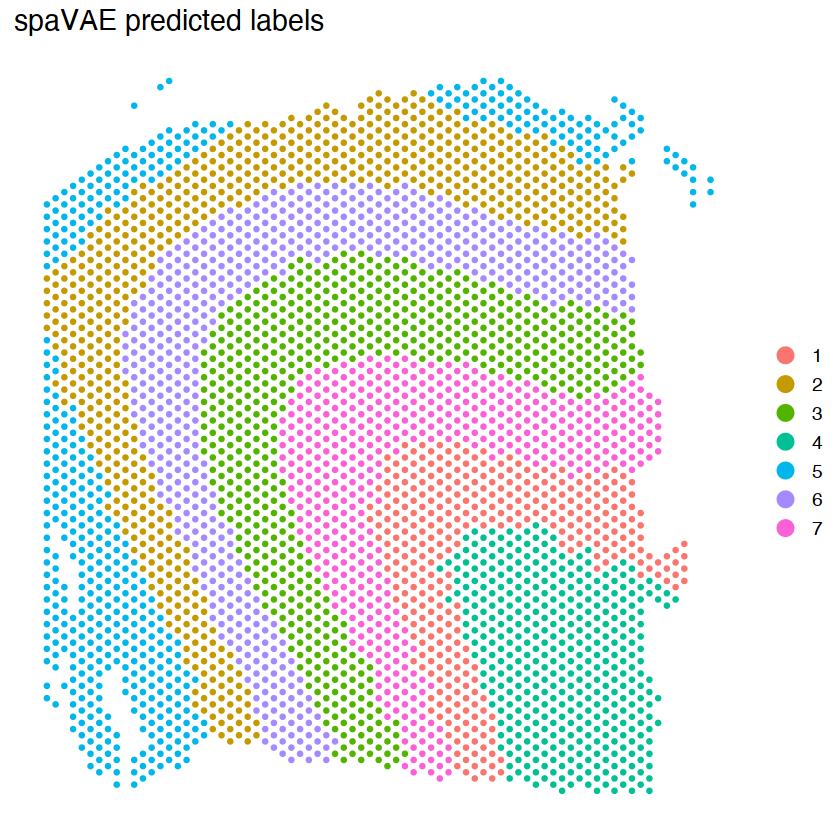

In [1]:
rm(list=ls())
library(ggplot2)
library(rhdf5)

pos <- t(h5read("sample_151673.h5", "pos"))
refined_pred <- as.numeric(readLines("refined_clustering_labels.txt"))+1

pred_dat <- data.frame(refined_pred=refined_pred, pos_x=pos[,1], pos_y=pos[,2])
pred_dat$refined_pred <- factor(pred_dat$refined_pred, levels=1:7)

ggplot(pred_dat, aes(x=pos_x, y=pos_y, color=refined_pred)) + geom_point(size=0.8) + 
  theme_classic() + ggtitle("spaVAE predicted labels") +
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), legend.position="right", text = element_text(size=14)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot latent embedding of spaVAE. Colors represent ground-truth labels.

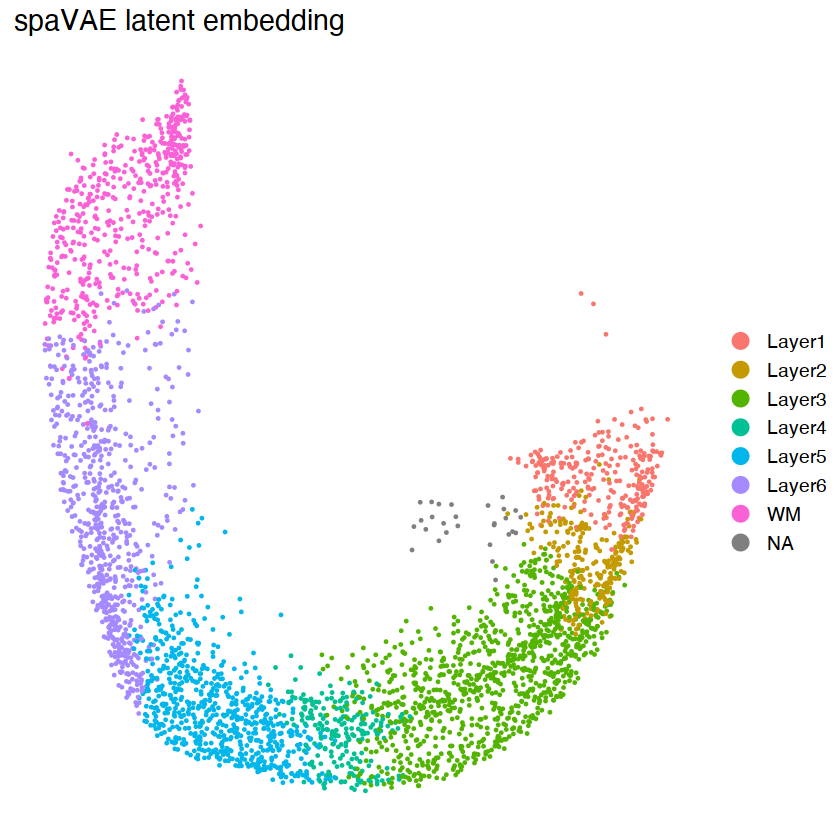

In [2]:
spaVAE_latent <- read.table("final_latent.txt", sep=",")
colnames(spaVAE_latent) <- c("X1", "X2")
Y <- h5read("sample_151673.h5", "Y") # load ground-truth labels
spaVAE_latent$Y <- Y

ggplot(spaVAE_latent, aes(x=X1, y=X2, color=Y)) + geom_point(size=0.3) + 
  ggtitle("spaVAE latent embedding") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot result of differential expression (DE) analysis. We use the pseudo-bulk DE result as ground-truth and calculate the correlation between spaVAE's LFC and pseudo-bulk DE statisitcs.

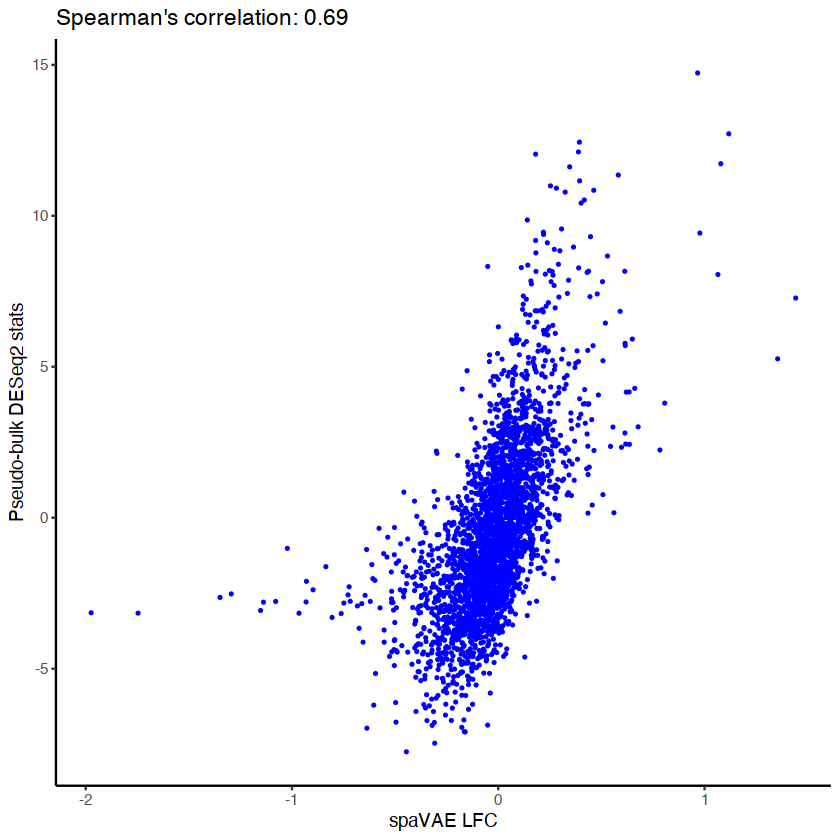

In [3]:
layer1_bulk_DE <- read.csv("Layer1_vs_others.csv", row.names = 1) # load pseudo-bulk DE result of layer1 vs others
layer1_LFC <- read.table("Layer1_vs_others_LFC.txt", sep=",", row.names = 1, header=T) # load spaVAE LFC of layer1 vs others
intersect.genes <- intersect(rownames(layer1_LFC), rownames(layer1_bulk_DE))

DE_dat <- data.frame(spaVAE=layer1_LFC[intersect.genes, "LFC"],
                    bulk=layer1_bulk_DE[intersect.genes, "stat"])

cor <- cor(DE_dat$spaVAE, DE_dat$bulk, method="spearman")

ggplot(DE_dat, aes(x=spaVAE, y=bulk)) + geom_point(color="blue", size=0.4) + 
    xlab("spaVAE LFC") + ylab("Pseudo-bulk DESeq2 stats") + ggtitle(paste("Spearman's correlation:", round(cor, 2))) +
    theme_classic()